# HarvestStat Data Profiling - Togo

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32631'
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/TG_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #


- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1982	 | TG1982A1 | 5	| TG1982A2	| 21	| nan	| 0	|
| 1995	 | TG1995A1 | 5	| TG1995A2	| 30	| nan	| 0	|
| 2009	 | TG2009A1 | 5	| TG2009A2	| 35	| nan	| 0	|
| 2016	 | TG2016A1 | 5	| TG2016A2	| 39	| nan	| 0	|
| 2017	 | TG2017A1 | 5	| TG2017A2	| 39	| nan	| 0	|
----------------------------------------------- #


In [3]:
# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Togo',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionfacts/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

In [4]:
# Save data
df_raw_out = '../data/crop_raw_data/adm_crop_data_raw_TG.csv'
df.to_csv(df_raw_out); print(f'{df_raw_out} is saved.')

../data/crop_raw_data/adm_crop_data_raw_TG.csv is saved.


In [5]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
#Drop the hundreds of blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]
df = df.dropna(subset=['admin_2'])

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# # FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([TG_Admin2_1982,TG_Admin2_1995,TG_Admin2_2009,TG_Admin2_2016,TG_Admin2_2017], axis=0)
PlotAdminShapes(shape_used, label=True)
# # ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 9,643
3,268/3,268 "Area Planted" points are retained.
3,188/3,188 "Quantity Produced" points are retained.
3,187/3,187 "Yield" points are retained.
Current data points: 9,643

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1990 - 2019
13 grain types are found: Bambara groundnut, Beans (mixed), Cassava, Cotton (Unspecified), Cowpea (unspecified), Groundnuts (In Shell), Maize (Corn), Millet, Rice (Paddy), Sorghum, Soybean (unspecified), Sweet Potatoes, Yams
2 seasons are found: Main (09-01), Annual (12-01)
1 crop production system are found: All (PS)
Data sources include:
[1] Direction des Statistiques Agricoles, de l'Informatique et de la Documentation, Togo --- Official agricultural statistics, Togo
[2] Direction Préfectoral des Statistiques de l'Informatique et de la Documentation, Togo --- Official agricultural statistics, Togo
[3] INSEED, Togo --

- Togo crop seasonal calendar

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/wafrica_to_calendar.png" width=900>

- comparison of boundaries

<img src="../figures/TG_admin_shapes.png" width=900>

- In Togo, basd on the FEWS NET data, there were five times of changes in administrative units: 1982, 1995, 2009, 2016, and 2017

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1982	 | TG1982A1 | 5	| TG1982A2	| 21	| nan	| 0	|
| 1995	 | TG1995A1 | 5	| TG1995A2	| 30	| nan	| 0	|
| 2009	 | TG2009A1 | 5	| TG2009A2	| 35	| nan	| 0	|
| 2016	 | TG2016A1 | 5	| TG2016A2	| 39	| nan	| 0	|
| 2017	 | TG2017A1 | 5	| TG2017A2	| 39	| nan	| 0	|


- Here, we use **`TG2009A2`** to represent all admin-level 2 crop data because although there are more recent (and older) admin boundaries, it doesn't appear to be used (e.g. no corresponding FNIDs). Only 1995 and 2009 boundaries have associated date
- Only one season for maize is available (main) despite the cropping calendar indicating multiple seasons


In [6]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = TG_Admin2_2009.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [7]:
# Link admin boundaries ------------------------- #
link_1995, over_1995 = FDW_PD_CreateAdminLink(TG_Admin2_1995, TG_Admin2_2009, 'ADMIN2', 'ADMIN2', prod, epsg)
# Crop specific ratios
link_ratio_1995 = FDW_PD_RatioAdminLink(link_1995, prod, over_1995, mdx_pss)
link_merged = [link_ratio_1995]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [8]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

All [country, season_name] are in the external season calendar.


## Postprocessing outlier removal

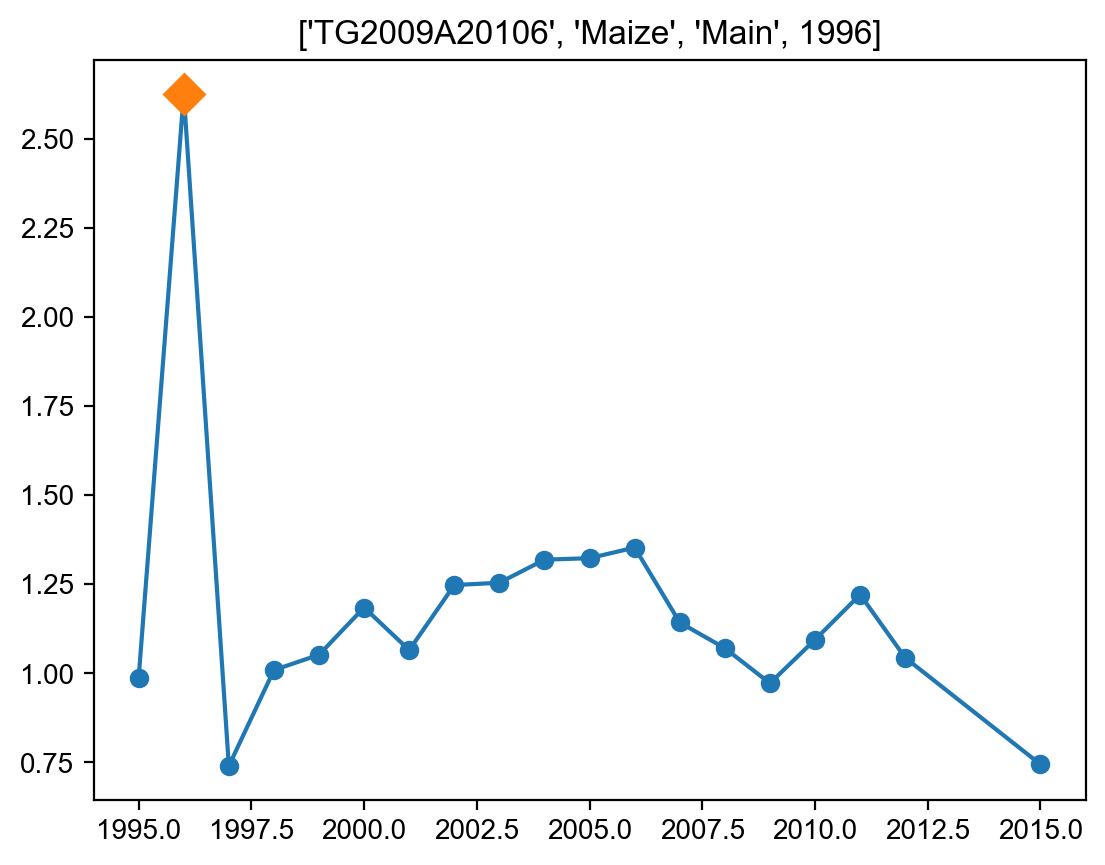

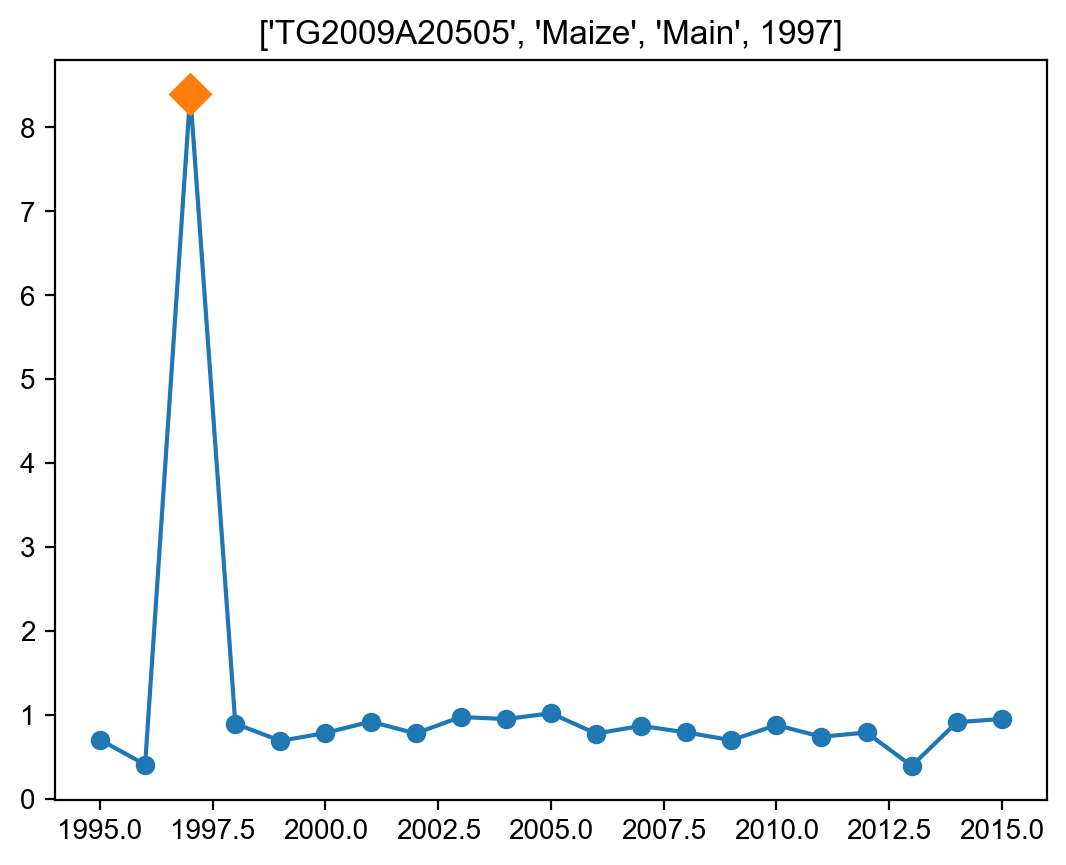

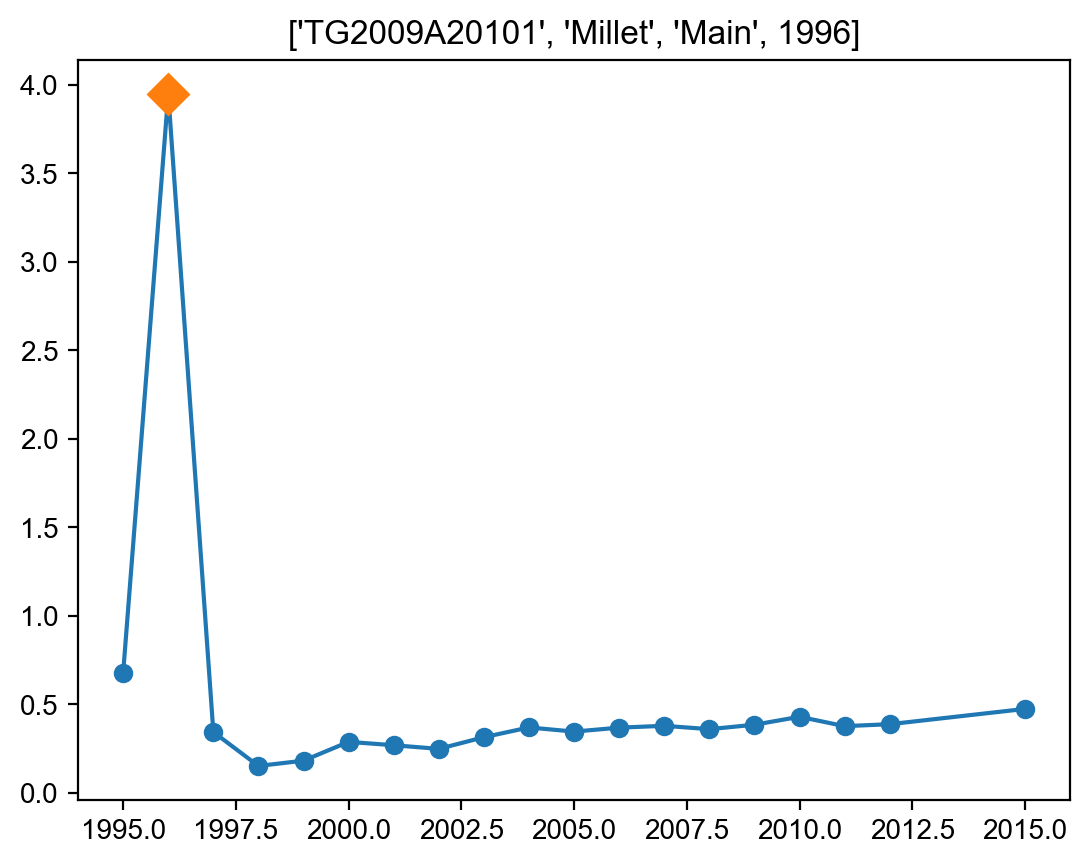

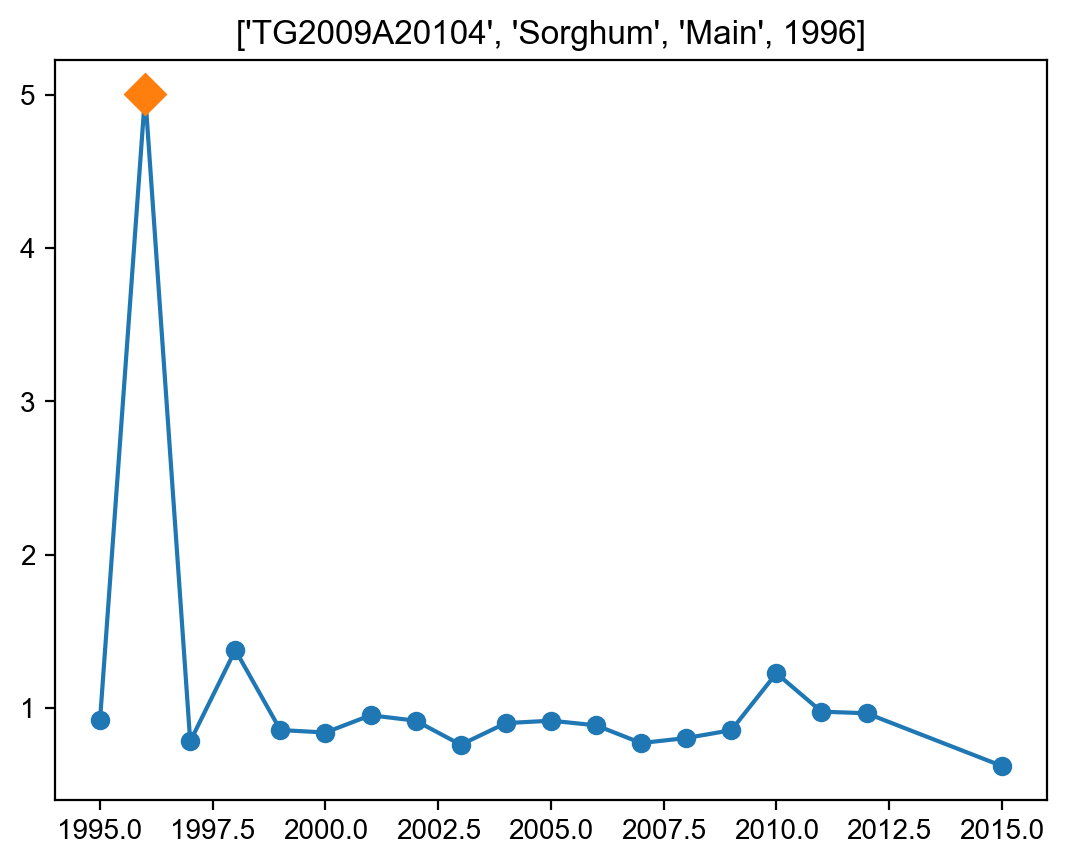

In [9]:
from matplotlib import pyplot as plt

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

outliers = [['TG2009A20106','Maize','Main',1996],
            ['TG2009A20505','Maize','Main',1997],
            ['TG2009A20101','Millet','Main',1996],
            ['TG2009A20104','Sorghum','Main',1996]
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title(str(iou))
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1


In [10]:
# Save data
fn_out = '../data/crop/adm_crop_production_TG.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_TG_ratio.npz', link_ratio)

../data/crop/adm_crop_production_TG.csv is saved.
../data/crop/adm_crop_production_TG_ratio.npz is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


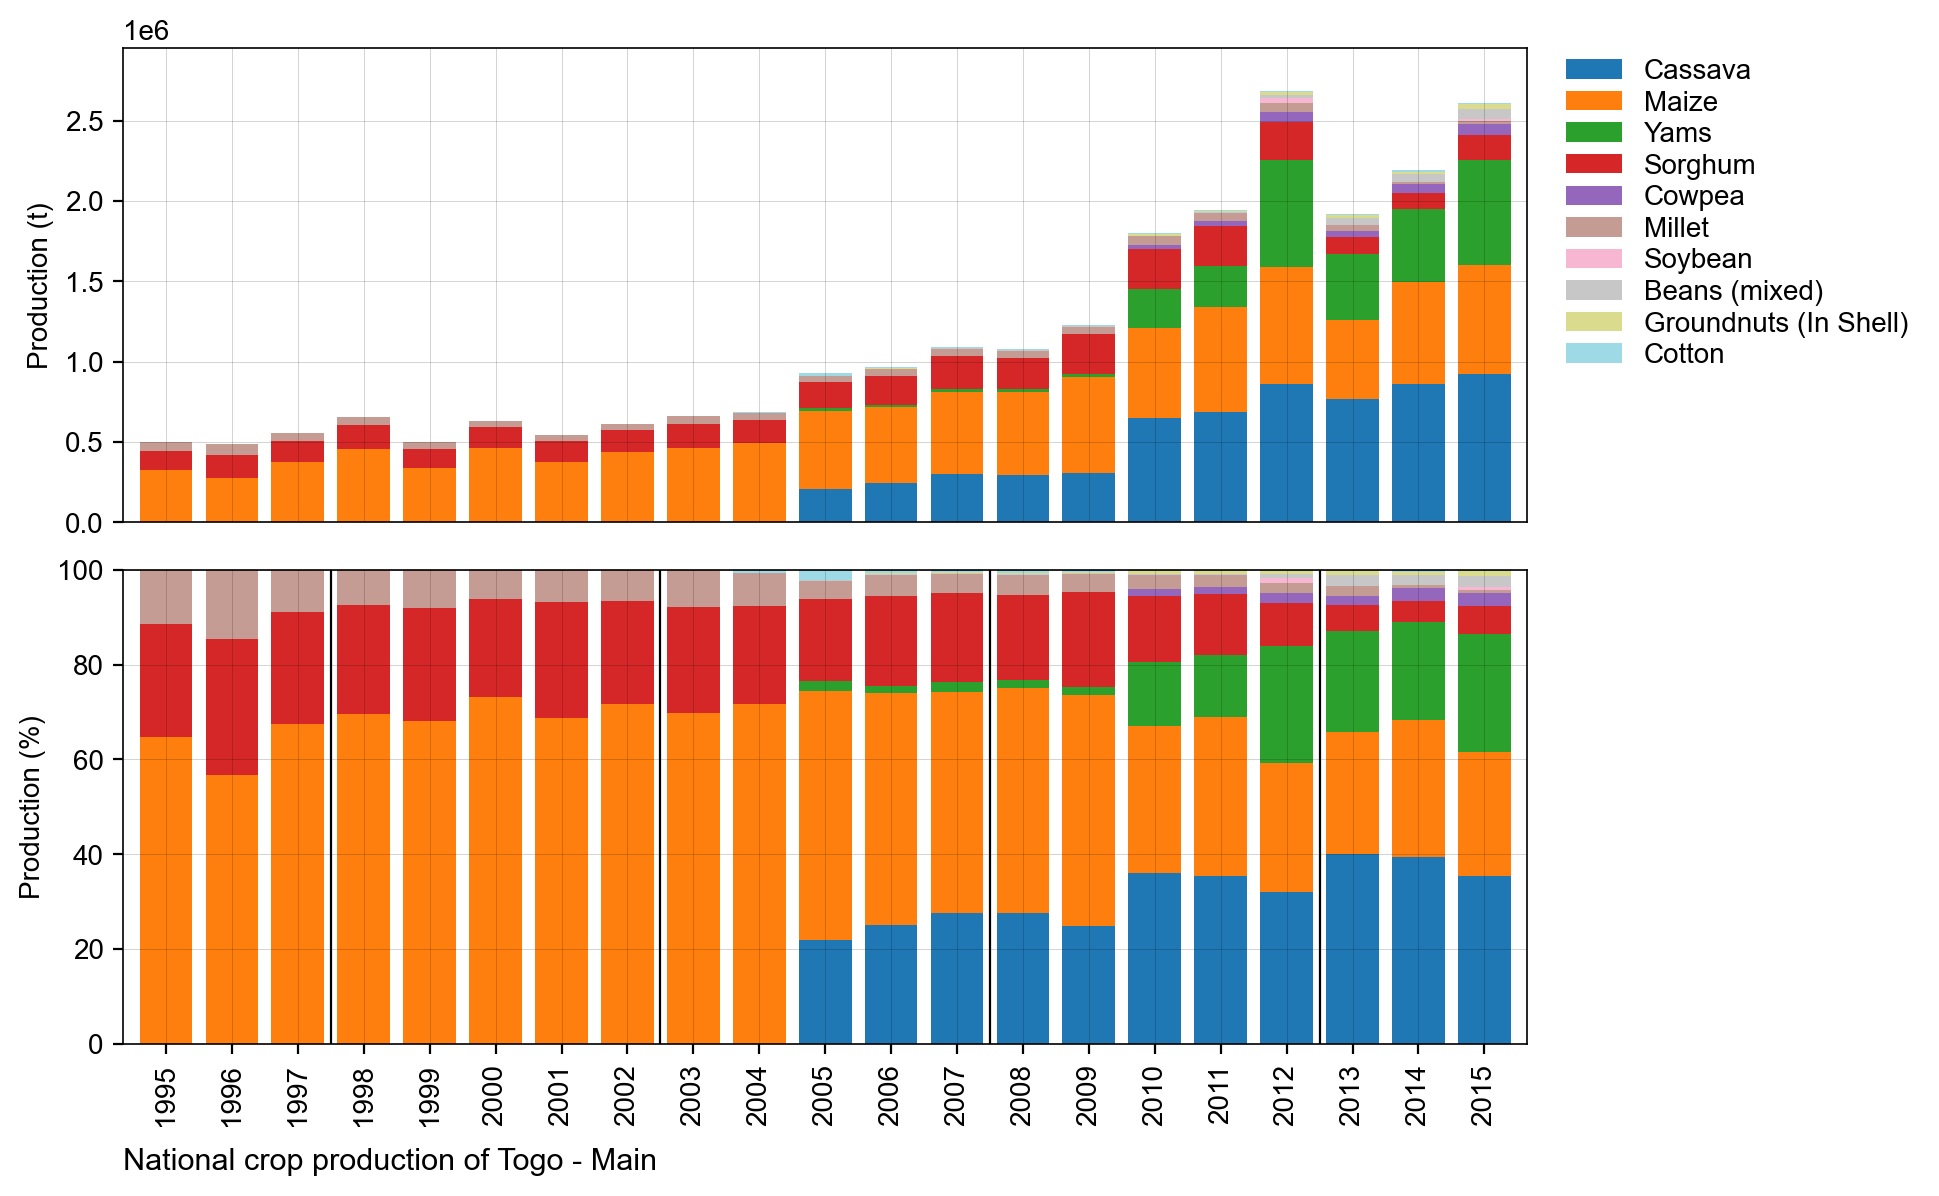

../figures/TG_bar_natgrainprod_Main.png is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


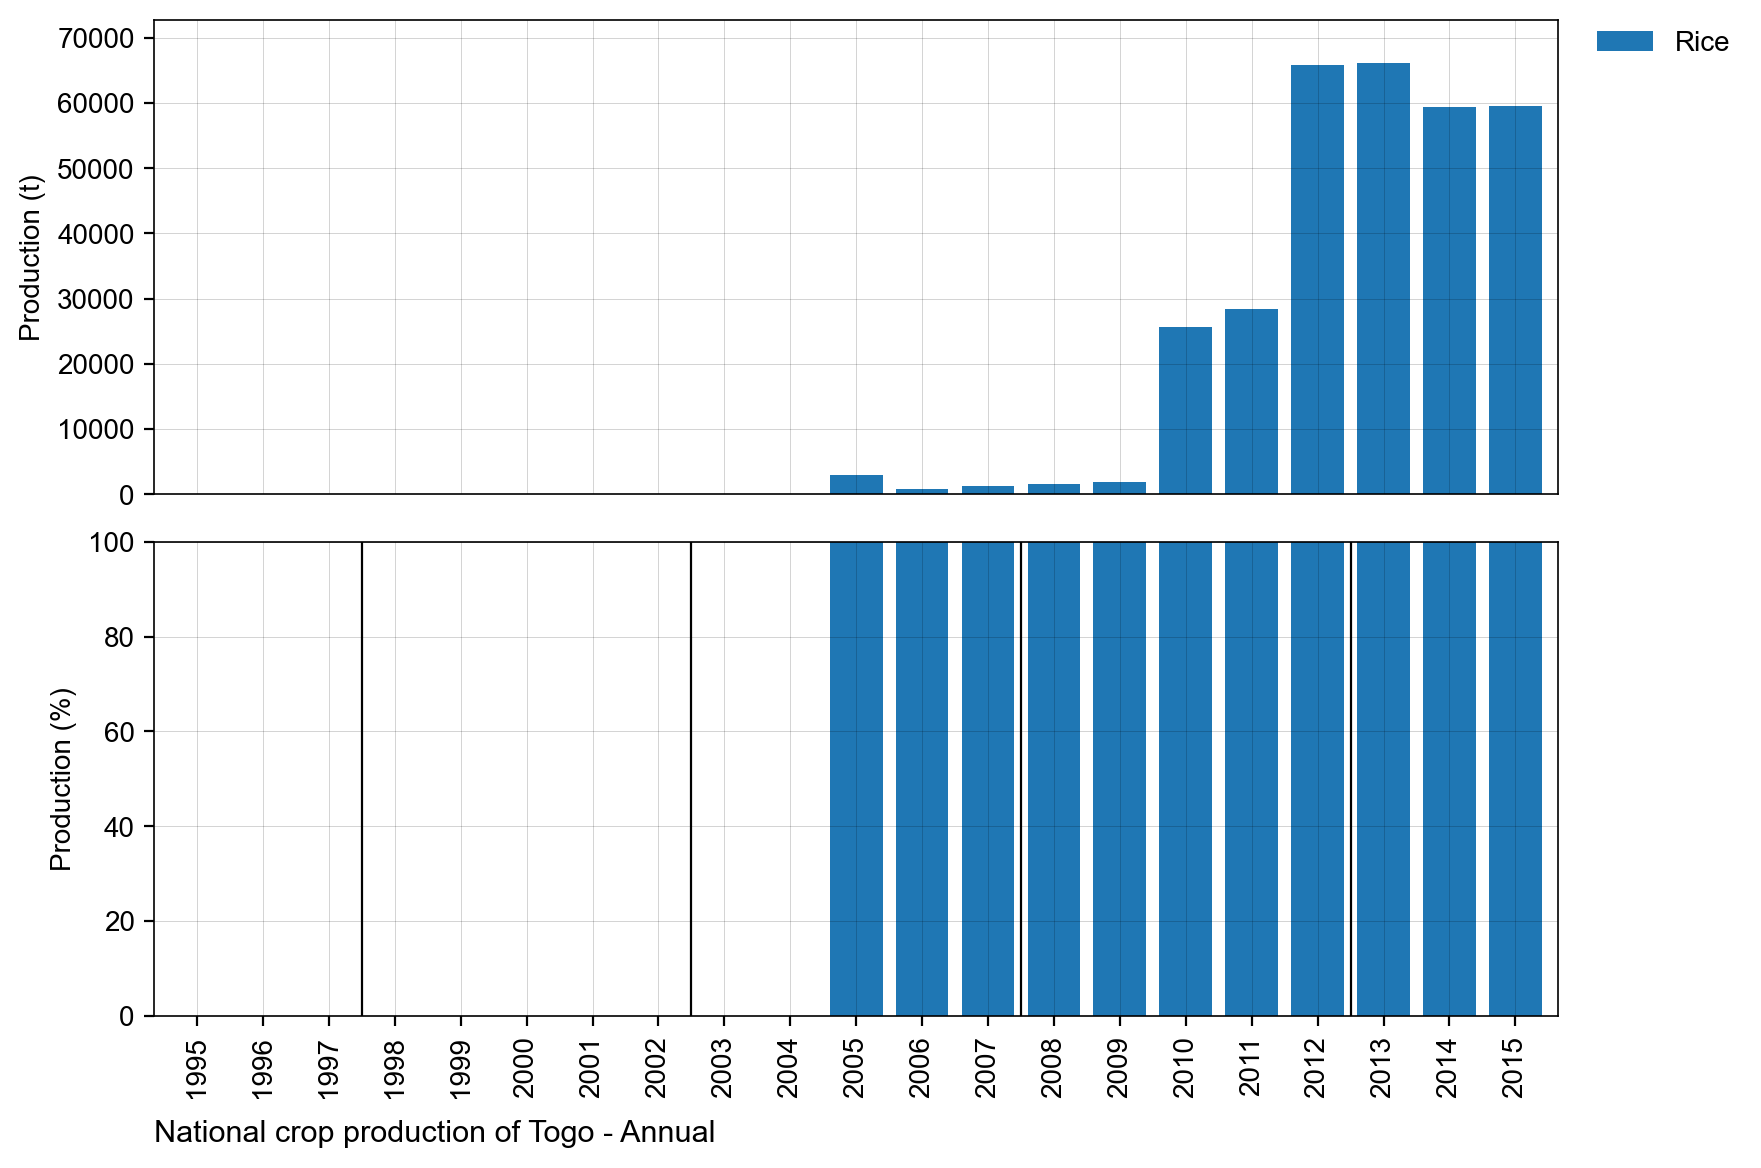

../figures/TG_bar_natgrainprod_Annual.png is saved.


In [11]:
# Bar chart of national crop production
country_iso, country_name = 'TG', 'Togo'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main','Annual']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

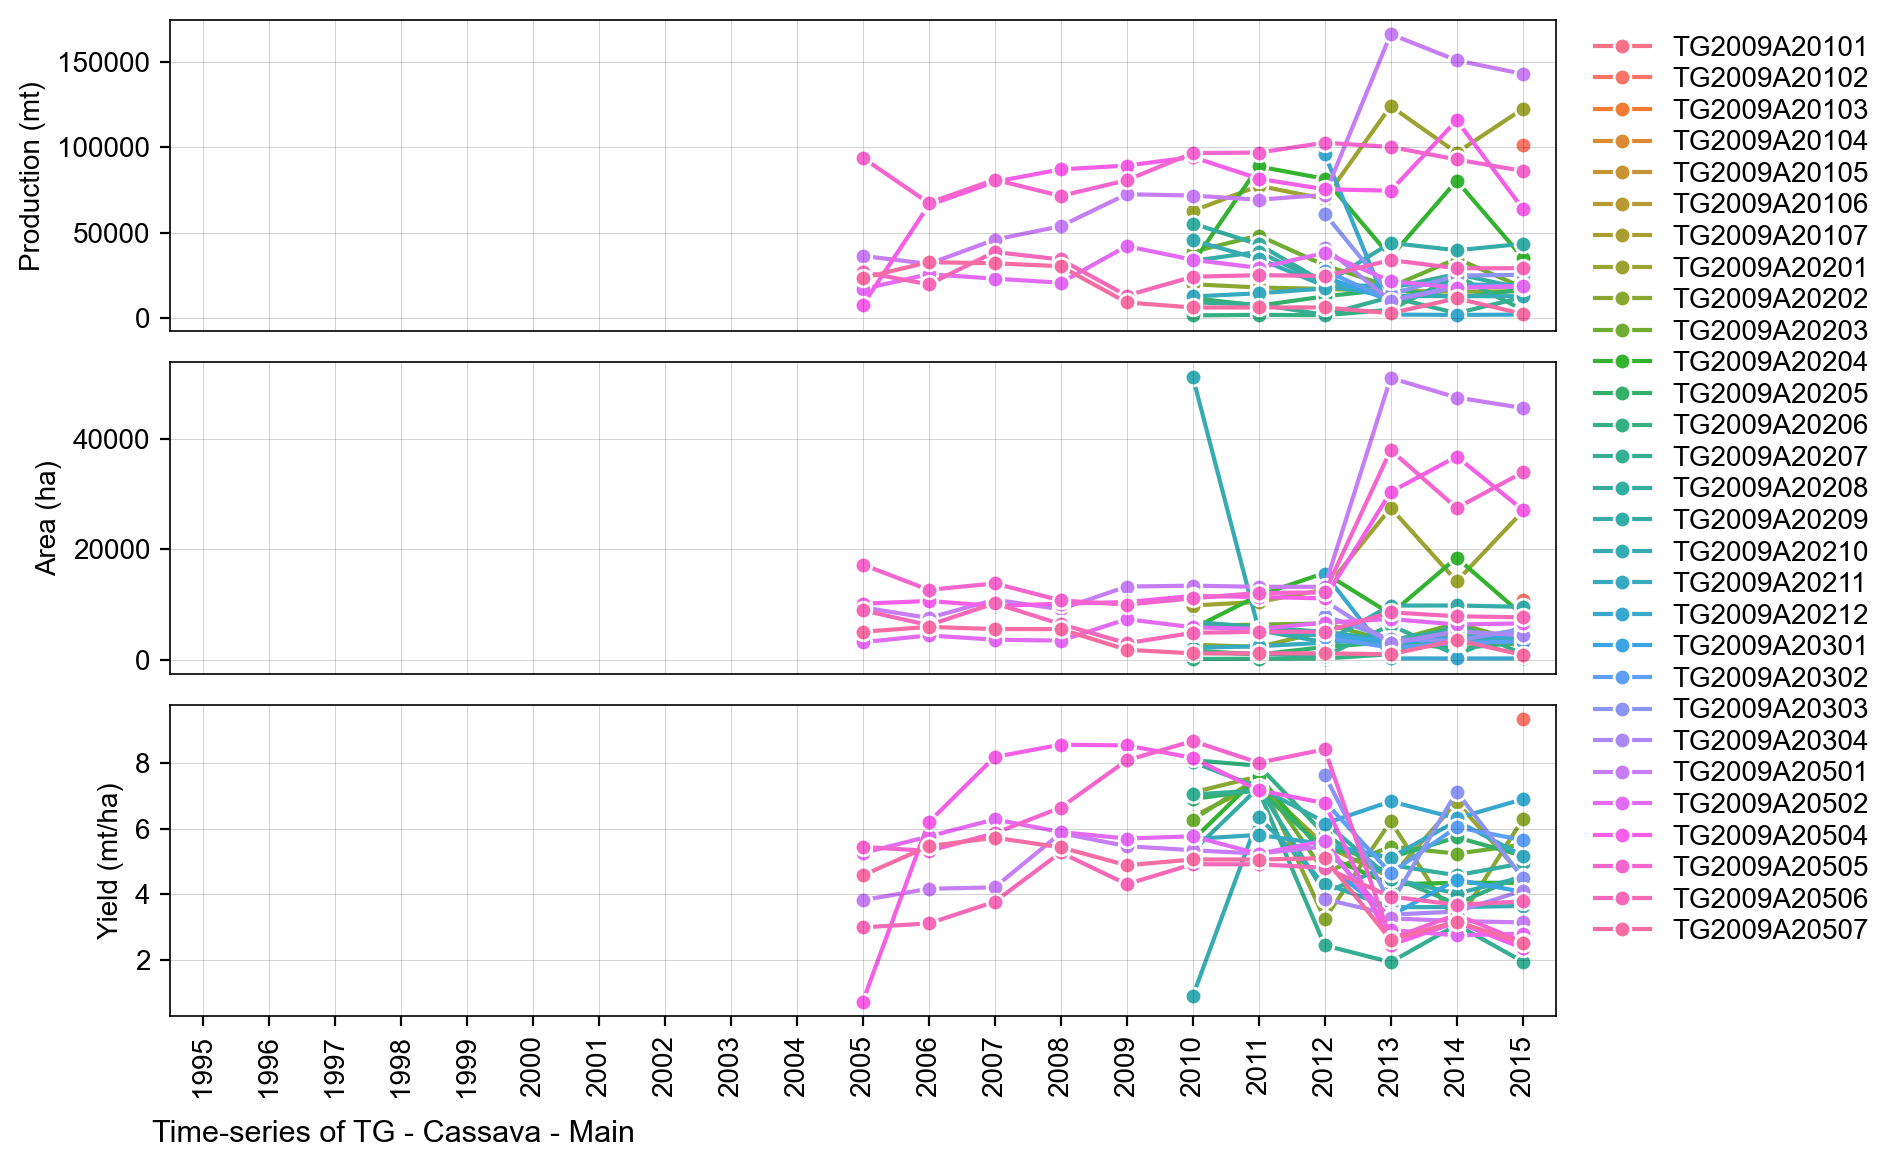

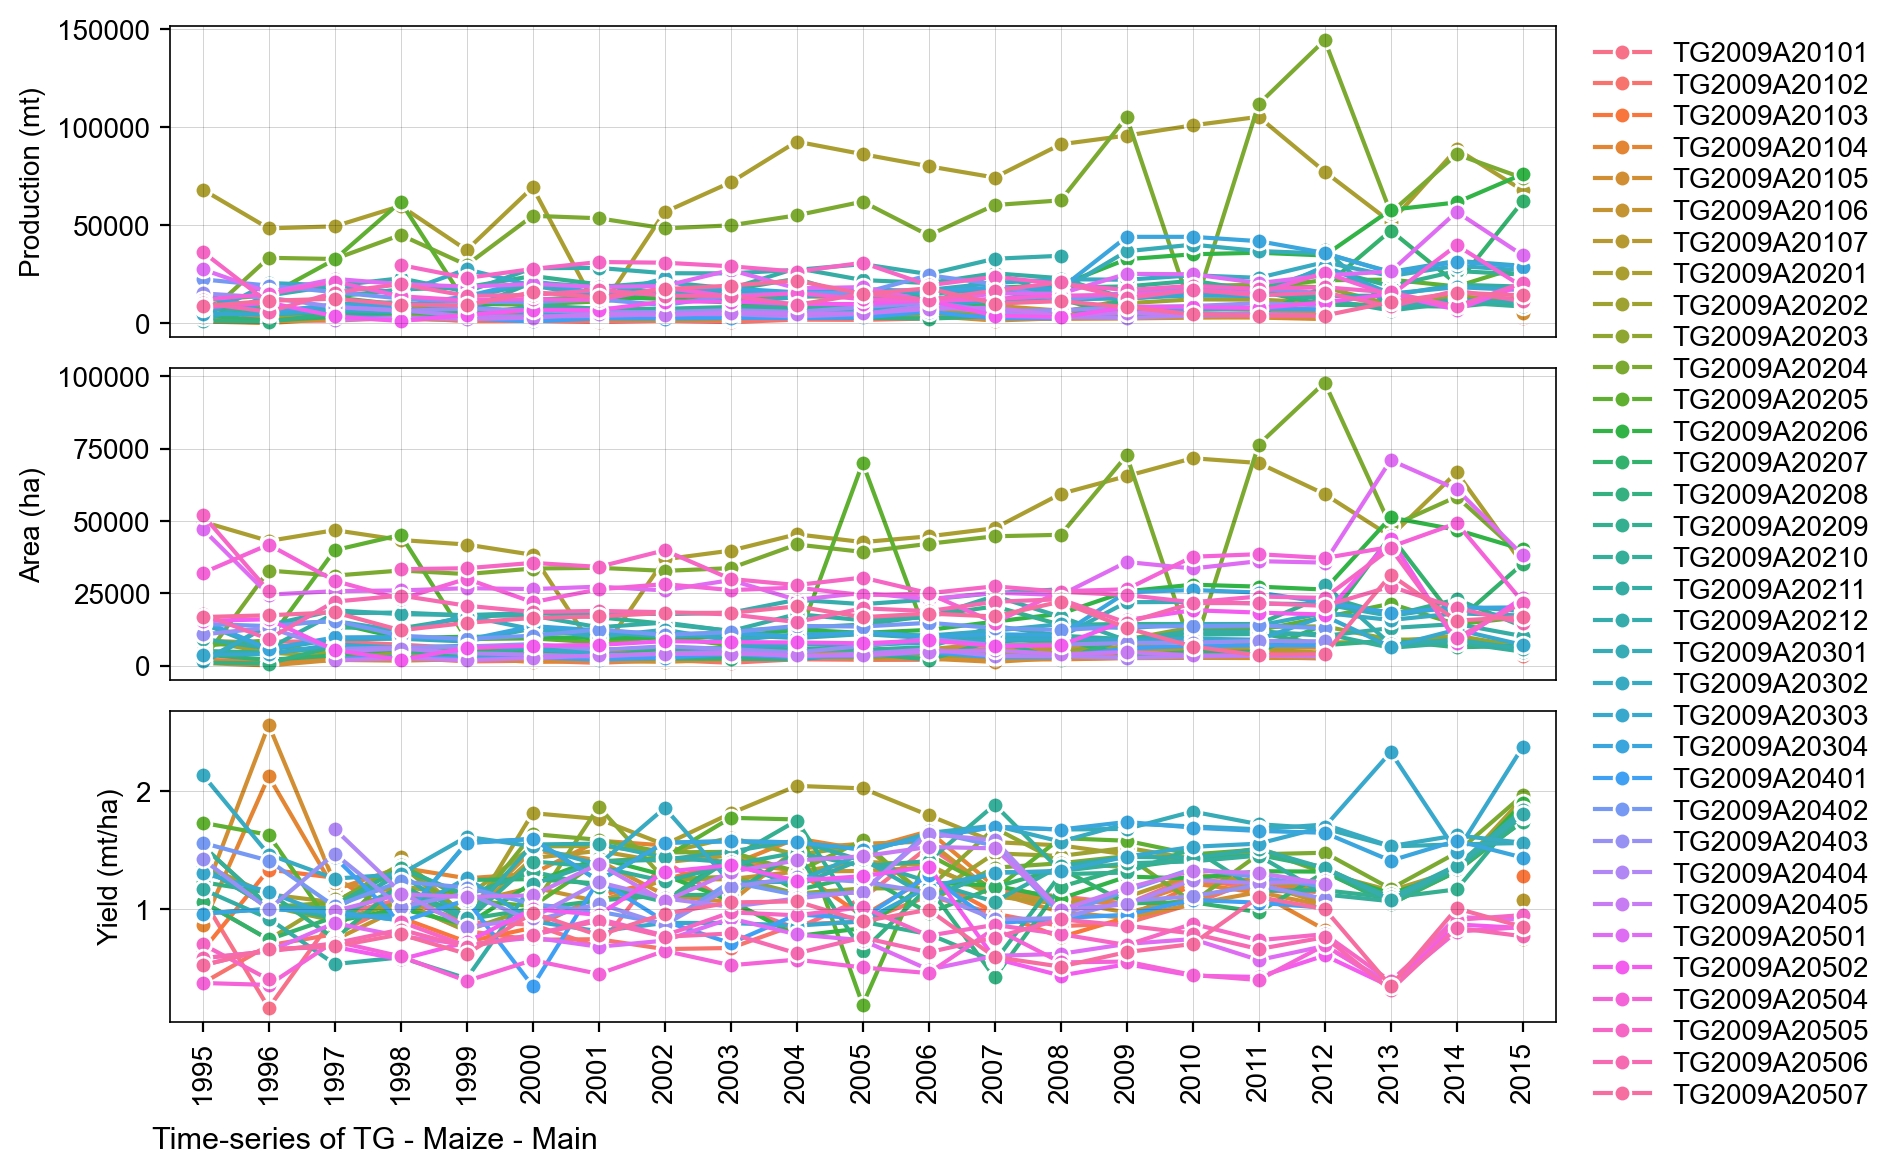

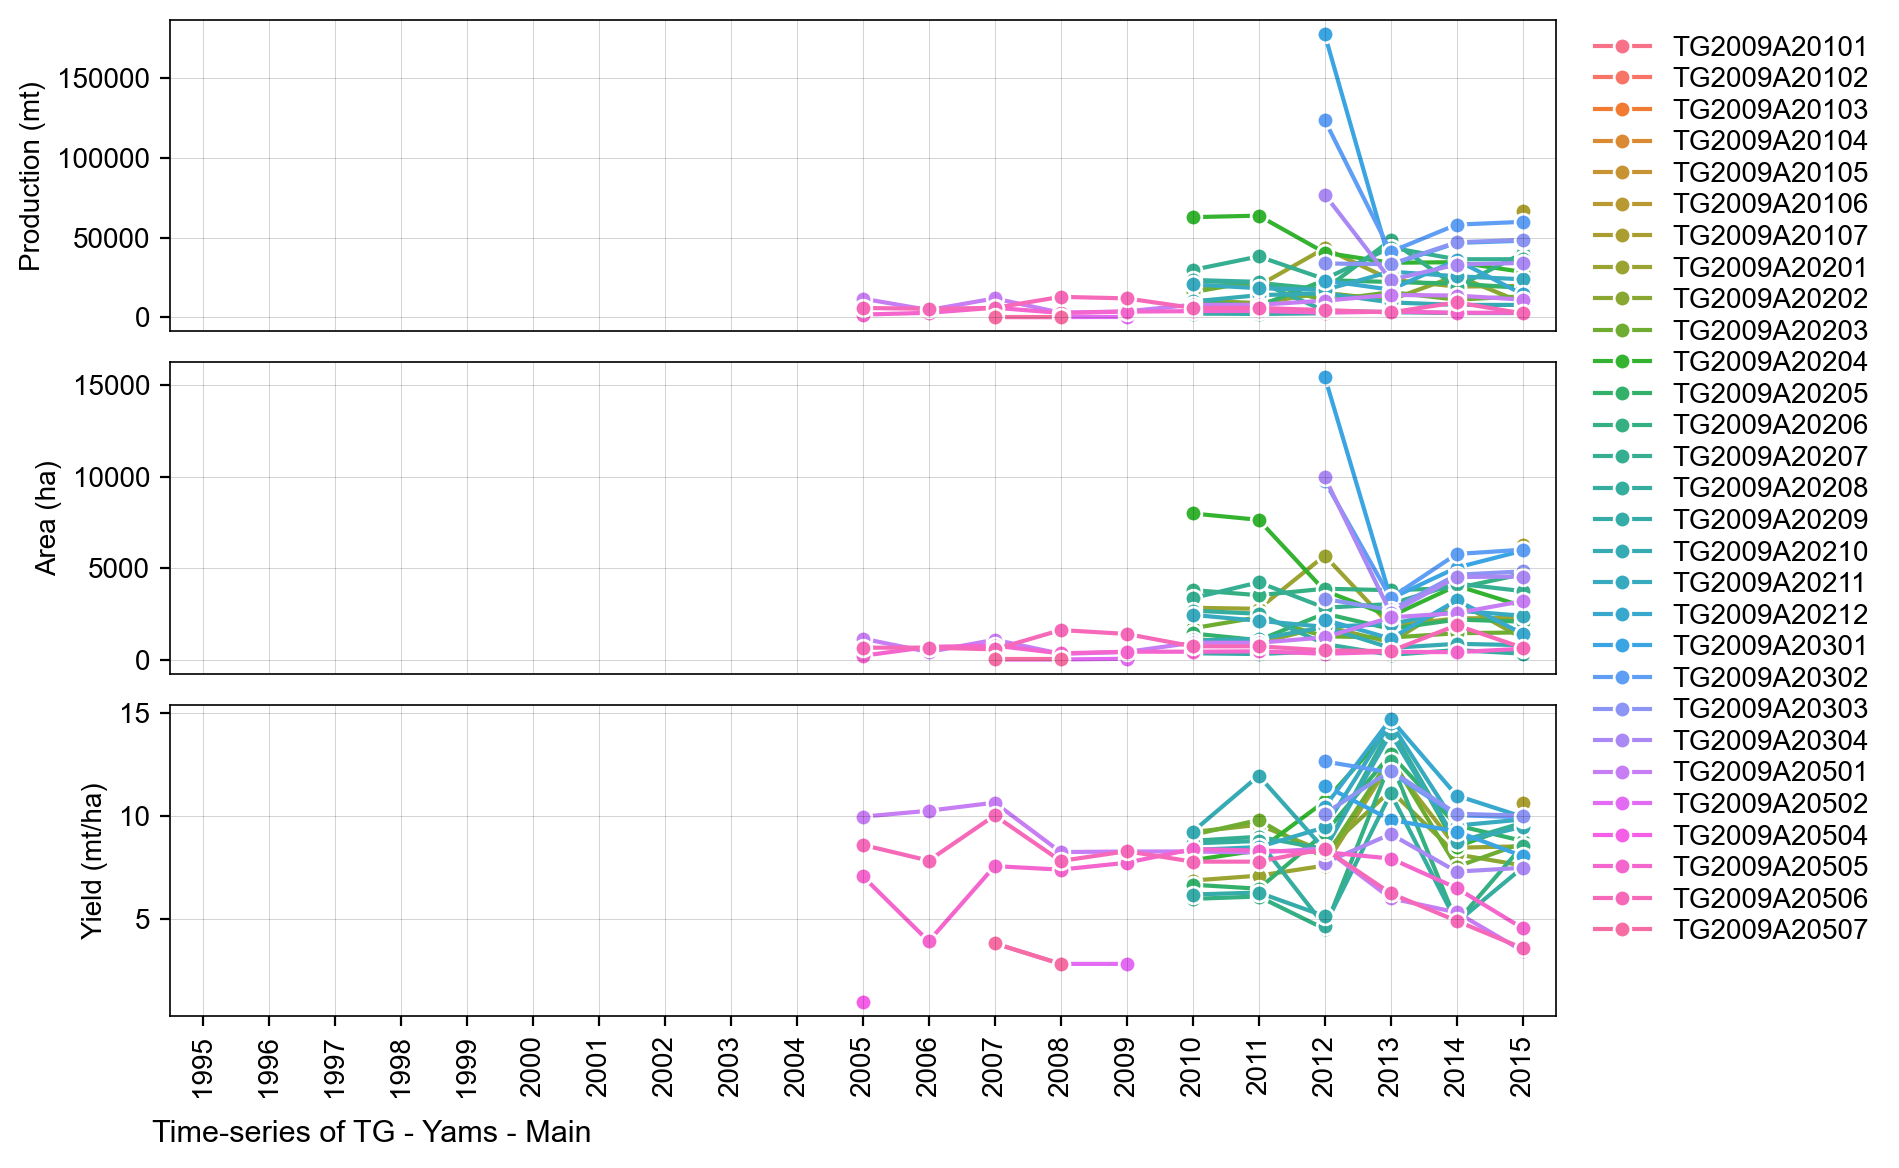

In [12]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'TG', 'Togo'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Cassava', 'Main'],
    ['Maize', 'Main'],
    ['Yams', 'Main'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)